## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.

## Loading Packages and Data

In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [285]:
train_data = pd.read_csv('Train.csv')

## Data Structure and Content

In [286]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [287]:
print("The train data has {} rows and {} columns".format(train_data.shape[0],train_data.shape[1]))

The train data has 8523 rows and 12 columns


In [288]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [289]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


C:\Users\mahmo\AppData\Local\Temp\ipykernel_4456\1024995339.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='cubehelix_r')


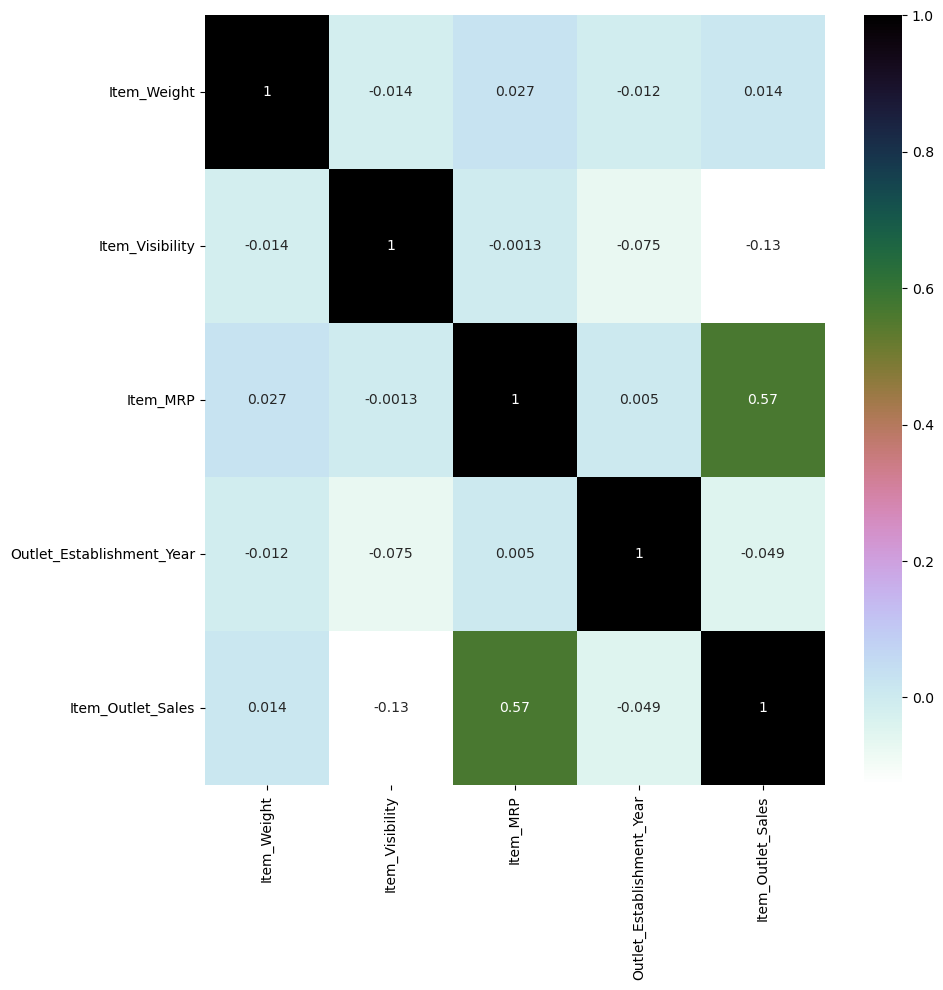

In [290]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True, cmap='cubehelix_r')
plt.show()

## Exploratory Data Analysis

We will visualize the data to see the relationship between different variables and and identify the distribution of values in categorical variables.

#### Helper Visualization Class

In [291]:
class HistogramPlotter():
    def __init__(self):
        pass

    def plot_hist(self, data, column_name, title, xlabel, ylabel):
        """
        This function plots a histogram for a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be plotted
        title (string): the title of the plot
        xlabel (string): the label of the x axis
        ylabel (string): the label of the y axis
        
        Returns:
        None
        """
        plt.title(title)
        data[column_name].hist()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(False)
        plt.show()

    def plot_hist_horizontal(self, data, column_name, title, xlabel, ylabel):
        """
        This function plots a horizontal histogram for a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be plotted
        title (string): the title of the plot
        xlabel (string): the label of the x axis
        ylabel (string): the label of the y axis

        Returns:
        None
        """
        plt.title(title)
        data[column_name].value_counts().plot(kind='barh')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(False)
        plt.show()

In [292]:
plotter = HistogramPlotter()

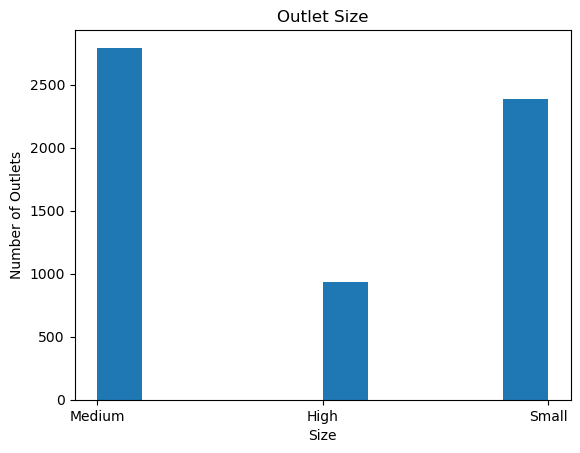

In [293]:
plotter.plot_hist(train_data, 'Outlet_Size', 'Outlet Size', 'Size', 'Number of Outlets')

From above we can see that number of outlets with size High is the smallest, small and medium outlets are almost equal in number.

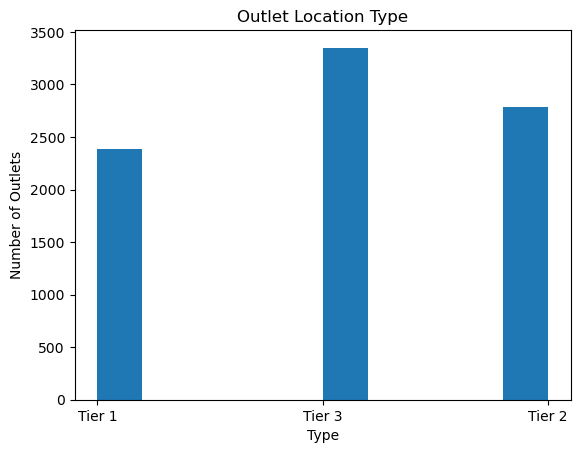

In [294]:
plotter.plot_hist(train_data, 'Outlet_Location_Type', 'Outlet Location Type', 'Type', 'Number of Outlets')

From the above plot, we can see that most of items are sell in outlets that are located in Tier 3.

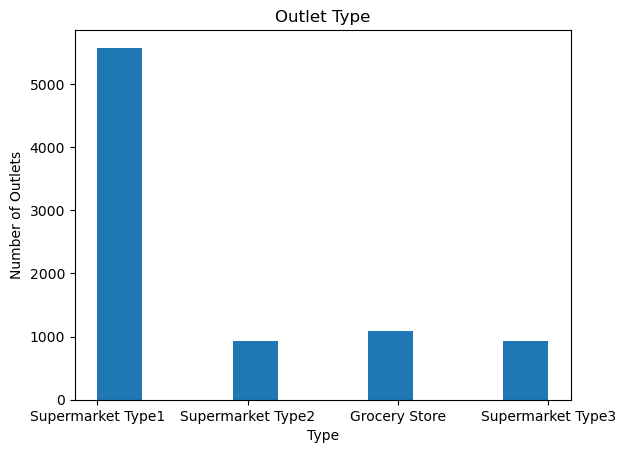

In [295]:
plotter.plot_hist(train_data, 'Outlet_Type', 'Outlet Type', 'Type', 'Number of Outlets')

From above plot, we can see that most of outlets exist are from type Supermarket Type1.

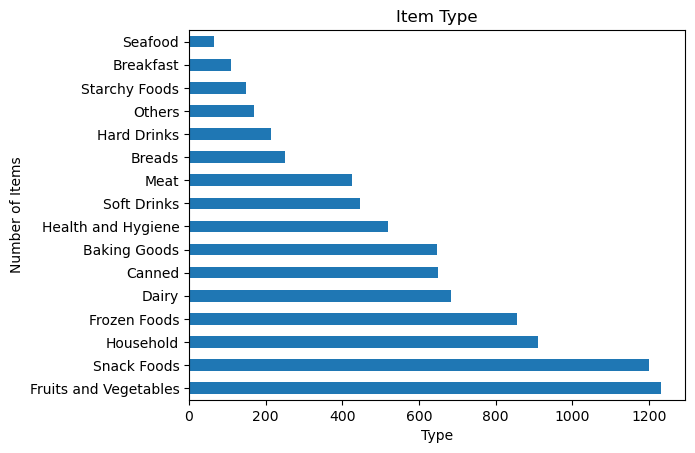

In [296]:
plotter.plot_hist_horizontal(train_data, 'Item_Type', 'Item Type', 'Type', 'Number of Items')

From the above plot, we can see that most of items are sell in outlets are snack foods, fruits and vegetables.

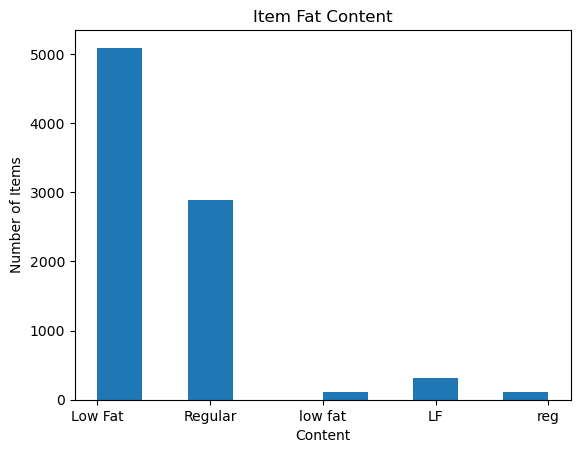

In [297]:
plotter.plot_hist(train_data, "Item_Fat_Content", "Item Fat Content", "Content", "Number of Items")

From the above plot, we can see that the Fat Content of most of items are low Fat and Regular.

In [298]:
# check for duplicate rows in the data
print("There are {} duplicate rows in the data".format(train_data.duplicated().sum()))

There are 0 duplicate rows in the data


## Missing Value Treatment

#### Helper Missing Values Class

In [299]:
class MissingValues():
    def __init__(self):
        pass
    
    def plot_missing_values(self, data):
        """
        This function plots a bar chart for the missing values in each column of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        None
        """
        plt.title("Missing Values")
        data.isnull().sum().plot(kind='bar')
        plt.xlabel("Columns")
        plt.ylabel("Number of missing values")
        plt.show()

    def count_missing_values(self, data):
        """
        This function counts the number of missing values in each column of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        number of missing values in each column
        """
        return data.isnull().sum()
    
    def impute_categorical_with_mode(self, data, column_name):
        """
        This function imputes the missing values in a given column with the mode of that column

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be imputed

        Returns:
        None
        """
        data[column_name].fillna(data[column_name].mode()[0], inplace=True)

    def impute_numerical_with_mean(self, data, column_name):
        """
        This function imputes the missing values in a given column with the mean of that column

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be imputed

        Returns:
        None
        """
        data[column_name].fillna(data[column_name].mean(), inplace=True)

In [300]:
missing_values = MissingValues()

In [301]:
missing_values.count_missing_values(train_data)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

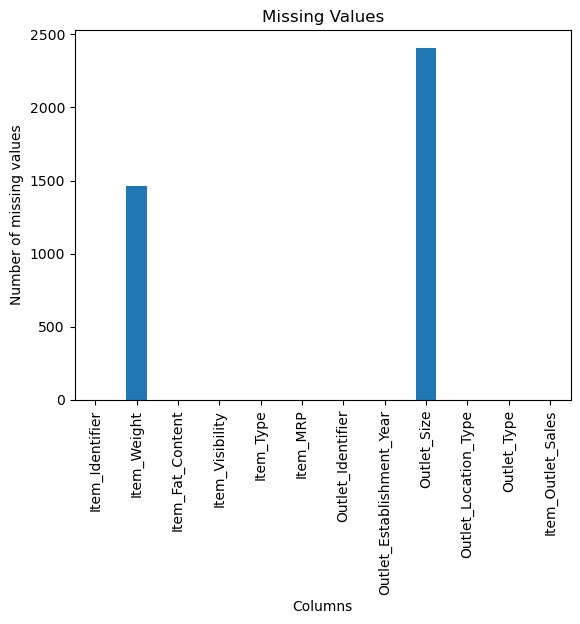

In [302]:
missing_values.plot_missing_values(train_data)

Now we have two columns that have missing values which are:
1. Item_Weight
2. Outlet_Size

One of them is categorical and the other is numerical. We will fill the missing values in Item_Weight with the mean of the column and the missing values in Outlet_Size with the mode of the column.

In [303]:
missing_values.impute_categorical_with_mode(train_data, 'Outlet_Size')
missing_values.impute_numerical_with_mean(train_data, 'Item_Weight')

#### Helper Outliers Class

In [304]:
class Outliers():
    def __init__(self):
        pass

    def plot_outliers(self, data, column_name):
        """
        This function plots a box plot for each column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        None
        """
        plt.title(column_name)
        sns.boxplot(data[column_name])
        plt.show()
    
    def remove_outliers(self, data, column_name):
        """
        This function removes the outliers in a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be used

        Returns:
        None
        """
        q1 = data[column_name].quantile(0.25)
        q3 = data[column_name].quantile(0.75)
        iqr = q3 - q1
        data = data[~((data[column_name] < (q1 - 1.5 * iqr)) | (data[column_name] > (q3 + 1.5 * iqr)))]
        return data

Now we will see the outliers in each column

In [305]:
outliers = Outliers()

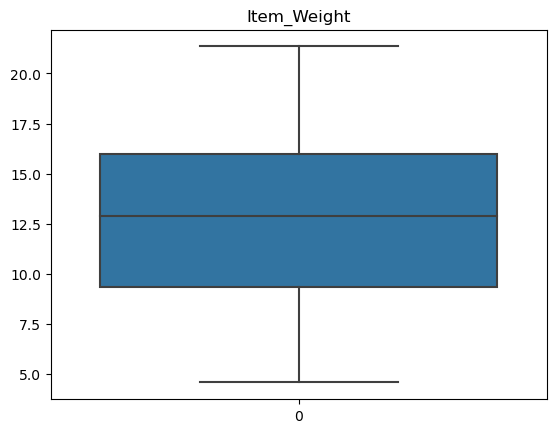

In [306]:
outliers.plot_outliers(train_data, 'Item_Weight')

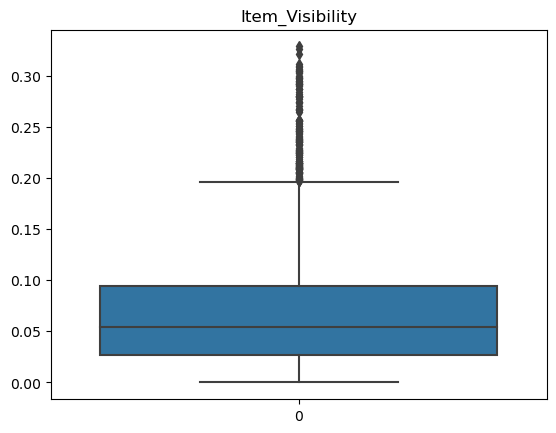

In [307]:
outliers.plot_outliers(train_data, 'Item_Visibility')

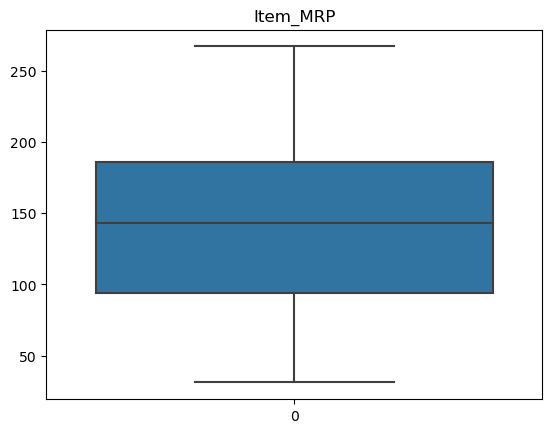

In [308]:
outliers.plot_outliers(train_data, 'Item_MRP')

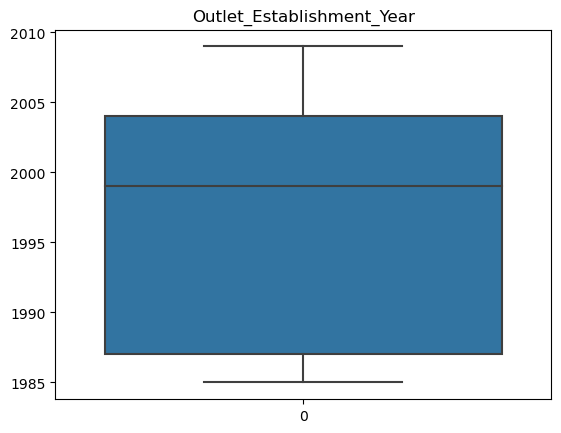

In [309]:
outliers.plot_outliers(train_data, 'Outlet_Establishment_Year')

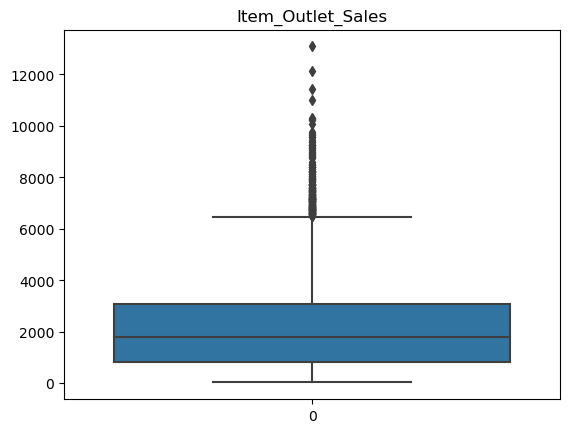

In [310]:
outliers.plot_outliers(train_data, 'Item_Outlet_Sales')

In [311]:
# remove the outliers from the data
train_data = outliers.remove_outliers(train_data, 'Item_Weight')
train_data = outliers.remove_outliers(train_data, 'Item_Visibility')
train_data = outliers.remove_outliers(train_data, 'Item_MRP')
train_data = outliers.remove_outliers(train_data, 'Outlet_Establishment_Year')
train_data = outliers.remove_outliers(train_data, 'Item_Outlet_Sales')

## One Hot Encoding

Now for each of the categorical columns, we will apply one hot encoding to convert them into numerical columns.

In [312]:
categorical_columns = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

In [313]:
train_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,1999,3735.1380,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,2009,443.4228,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,17.50,0.016760,141.6180,1999,2097.2700,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,1998,732.3800,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,8.93,0.000000,53.8614,1987,994.7052,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


## Univariate Analysis

## Bivariate Analysis

## Feature Engineering

## PreProcessing Data

In [282]:
# divide the data into features and target
X = train_data.drop('Item_Outlet_Sales', axis=1)
y = train_data[['Item_Outlet_Sales']]

Now we will scale the data using StandardScaler to make the data normally distributed.

In [251]:
scaler = StandardScaler()
numerical_colums = ['Item_Weight', 'Item_Visibility', 'Item_MRP'] 
scaler.fit(X[numerical_colums])
X[numerical_colums] = scaler.transform(X[numerical_colums])

## Modeling

#### Helper Trainer Class

In [318]:
class Trainer():
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test 
        self.y_test = y_test

    def train_model(self, model):
        """
        This function trains a given model and calculates the MSE on test data

        Parameters:
        model: the model to be trained
        X_train (dataframe): the training data
        y_train (dataframe): the training target
        X_test (dataframe): the test data
        y_test (dataframe): the test target

        Returns:
        MSE on test data
        """
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        return mean_squared_error(self.y_test, y_pred)
    
    def plot_MSE(self, MSE_values):
        """
        This function plots the MSE values for different models

        Parameters:
        MSE_values (list): a list of MSE values

        Returns:
        None
        """
        plt.title("MSE Values")
        plt.plot(MSE_values)
        plt.xlabel("Models")
        plt.ylabel("MSE")
        plt.show()

In this stage we will use different Machine Learning algorithms to predict the sales of each product at a particular store. We will use the following algorithms:
1. Linear Regression
2. Regularized Linear Regression
3. Random Forest
4. XGBoost

In [156]:
linear_regression = LinearRegression()
regularized_lr = Lasso()
random_forest = RandomForestRegressor()
xgb_regressor = xgb.XGBRegressor()

Now we will use the above Machine Learning algorithms with the default parameters to train the model and the algorithm that gives the best accuracy will be used for further tuning.

In [ ]:
trainer = Trainer(X_train, y_train, X_test, y_test)

In [ ]:
models = [linear_regression, regularized_lr, random_forest, xgb_regressor]
mse_values = []
for model in models:
    mse_value = trainer.train_model(model)
    mse_values.append(trainer.train_model(model))

In [ ]:
trainer.plot_MSE(mse_values)